# Ex18. 프로젝트 : 다양한 OCR모델 비교하기

## ⭐️ 기획한 서비스

----------------------------
* 서비스명 : 다 잡아!!
* 서비스 설명
   - 제품 라벨에 있는 텍스트를 인식하여 품질을 검사하기
   - 포장이 일치하는지, 잘못 인쇄되어 있지 않은지 등등
* 모델 평가 기준
    - 어둡거나 누워있거나 해도 잘 인식하는가?

## ✅ 목차

---------------------

### ▶️ Step1. 검증용 데이터셋 준비
### ▶️ Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
### ▶️ Step3. 테스트 결과 정리
### ▶️ Step4. 결과 분석과 결론 제시

--------------------------

## Step1. 검증용 데이터셋 준비

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
from google.cloud import vision
import io

In [2]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/product'
file_list = os.listdir(img_dir)
file_list

['image1.jpg',
 'image6.jpg',
 'image2.jpg',
 'image5.jpg',
 'image10.jpg',
 'image4.jpg',
 'image3.jpg',
 'image9.jpg',
 'image8.jpg',
 'image7.jpg']

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1) Google OCR API

In [3]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[image1.jpg]
Texts:

"FABERLIC
Bioglow
My way to
use less
makeup
Крем
с жемчужным
эффектом
Illuminating
face cream
30 M/ml
FABERLIC
Bioglow
You're my
sunshine
Сыворотка
для лица
Serum
"

"FABERLIC"

"Bioglow"

"My"

"way"

"to"

"use"

"less"

"makeup"

"Крем"

"с"

"жемчужным"

"эффектом"

"Illuminating"

"face"

"cream"

"30"

"M/ml"

"FABERLIC"

"Bioglow"

"You're"

"my"

"sunshine"

"Сыворотка"

"для"

"лица"

"Serum"
bounds: (1156,4271),(1245,4312),(1229,4346),(1140,4305)

[image6.jpg]
Texts:

"sin d'un lavage de mains efficace. Ce produit est enrichi en extrais dO
Bel Lavant Résurrection Aromatique pour les Mains
lendarin Rind Rosemary Leaf • Cedar Atlas
esurrection Aromatique Hand Wash
Orange, Rosemary and Lavender.
sperior cleansing gel for hard-working hands. Use whenever and itern
auire effective hand washing. This product is enhanced with botansa
aarant exceptionnel pour mains malmenées. A utiliser à chaque fois que
rce de Mandarine • Feuille de Romarin • Cèdre de l'Atlas
Ae

### 2) keras-ocr

In [6]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


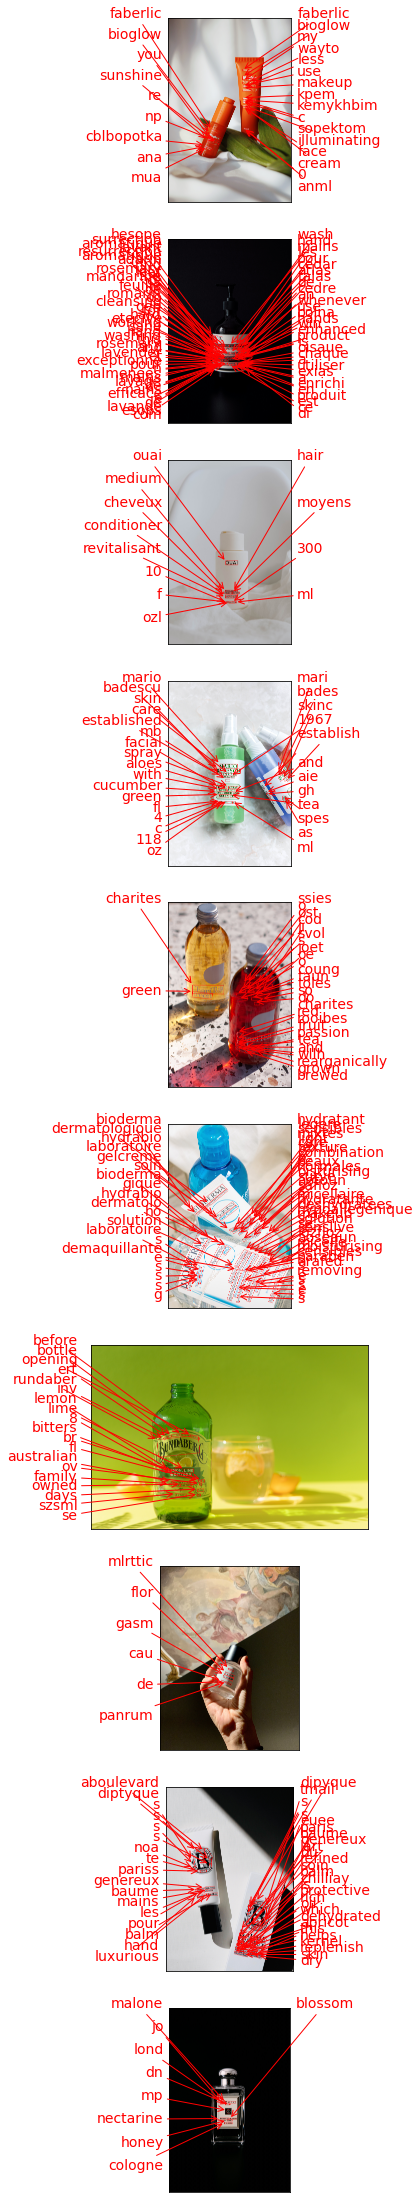

In [8]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3) Tesseract

In [9]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [10]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[image1.jpg]

c.


FABERLIC

—_


MY


a5

use



Pe Ce

a

eta ats

face cream

4


Done
[image6.jpg]

-


4

]

re

Ferd

“UTECtiOn

Aroma

tig

t=


ue

pour les

avant

Resurrection

Aromatiq

i

-aVan


oe

edar

A

arin

Rind

.

Rosemary

Leaf


C

A de

Mandarin

de

‘me

Cédre

:

pay

(>

©

Feuille

de

alll

Ghicmis

tel

.

nanas

- *

181%

Te

gel for

gage dtd

is enn

aw rs

and

Was

hing.

aT

and

Lavender

A utiliser

~

nees.

=

“ptionne:

Your

mains

iT}

Co Ba

est

_

Ue

de

Mains

efficace.

=") @

Ue

-aVande.

=

Done
[image2.jpg]

Done
[image5.jpg]
SKIN

CARE

Fstablished

1967

‘ACIAL

SPRAY

WITH

ALOE.

UCUMBER

AND


GREEN

TEA

\y


Done
[image10.jpg]
|

Done
[image4.jpg]

Done
[image3.jpg]

:

ws i

i

(py


Ie

%

,

tig


LEMON

mm)

— . :

Done
[image9.jpg]

Done
[image8.jpg]

Done
[image7.jpg]
JO

VIALONE

| OND ON

## Step3. 테스트 결과 정리

In [16]:
def compare_ocr(file):
    
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))
    print('-------------------------------------------')
    
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('-------------------------------------------')
    
    print('\n[Tesseract]')
    recognize_images(os.path.join(img_dir, file), save_dir)

### 1) 그림자 진 제품


[Google OCR]
Texts:

"sin d'un lavage de mains efficace. Ce produit est enrichi en extrais dO
Bel Lavant Résurrection Aromatique pour les Mains
lendarin Rind Rosemary Leaf • Cedar Atlas
esurrection Aromatique Hand Wash
Orange, Rosemary and Lavender.
sperior cleansing gel for hard-working hands. Use whenever and itern
auire effective hand washing. This product is enhanced with botansa
aarant exceptionnel pour mains malmenées. A utiliser à chaque fois que
rce de Mandarine • Feuille de Romarin • Cèdre de l'Atlas
Aesop.
les Mains
ange, Rosemary and Lavender.
marin et de Lavande.
16,9
3esop.com
"

"sin"

"d'un"

"lavage"

"de"

"mains"

"efficace."

"Ce"

"produit"

"est"

"enrichi"

"en"

"extrais"

"dO"

"Bel"

"Lavant"

"Résurrection"

"Aromatique"

"pour"

"les"

"Mains"

"lendarin"

"Rind"

"Rosemary"

"Leaf"

"•"

"Cedar"

"Atlas"

"esurrection"

"Aromatique"

"Hand"

"Wash"

"Orange,"

"Rosemary"

"and"

"Lavender."

"sperior"

"cleansing"

"gel"

"for"

"hard-working"

"hands."

"U

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


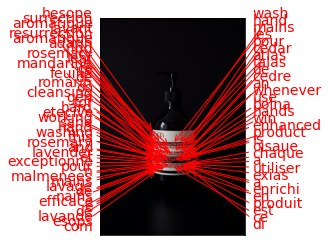

-------------------------------------------

[Tesseract]

-


4

]

re

Ferd

“UTECtiOn

Aroma

tig

t=


ue

pour les

avant

Resurrection

Aromatiq

i

-aVan


oe

edar

A

arin

Rind

.

Rosemary

Leaf


C

A de

Mandarin

de

‘me

Cédre

:

pay

(>

©

Feuille

de

alll

Ghicmis

tel

.

nanas

- *

181%

Te

gel for

gage dtd

is enn

aw rs

and

Was

hing.

aT

and

Lavender

A utiliser

~

nees.

=

“ptionne:

Your

mains

iT}

Co Ba

est

_

Ue

de

Mains

efficace.

=") @

Ue

-aVande.

=

Done


In [17]:
compare_ocr('image6.jpg')


[Google OCR]
Texts:

"HERETIC
FLOR
GASM
EAU DE PARFUM
"

"HERETIC"

"FLOR"

"GASM"

"EAU"

"DE"

"PARFUM"
bounds: (1443,2550),(1550,2594),(1541,2616),(1434,2572)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


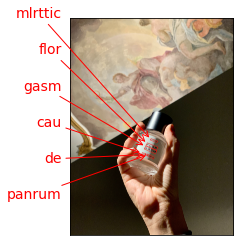

-------------------------------------------

[Tesseract]

Done


In [18]:
compare_ocr('image9.jpg')


[Google OCR]
Texts:

"Rooibos tea with passion
fruit, organically grown
and real brewed
ChariTea
red
ChariTe
green
bed
"

"Rooibos"

"tea"

"with"

"passion"

"fruit,"

"organically"

"grown"

"and"

"real"

"brewed"

"ChariTea"

"red"

"ChariTe"

"green"

"bed"
bounds: (731,2319),(821,2335),(812,2381),(723,2364)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


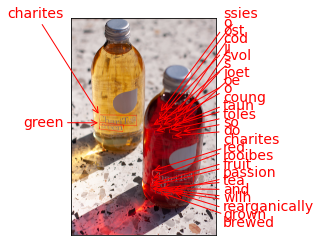

-------------------------------------------

[Tesseract]
|

Done


In [19]:
compare_ocr('image10.jpg')


[Google OCR]
Texts:

"INVERT BOTTLE BEFORE OPENING
\DABI
BER
LEMON, LIME
& BITTERS
BREW
AUSTRALIAN
FAMILY OWNED
OVE
7.
DAYS
AFT
INERGY
DI
ENE
375ML
CRAF
"

"INVERT"

"BOTTLE"

"BEFORE"

"OPENING"

"\DABI"

"BER"

"LEMON,"

"LIME"

"&"

"BITTERS"

"BREW"

"AUSTRALIAN"

"FAMILY"

"OWNED"

"OVE"

"7."

"DAYS"

"AFT"

"INERGY"

"DI"

"ENE"

"375ML"

"CRAF"
bounds: (2044,2847),(2175,2698),(2229,2745),(2098,2895)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


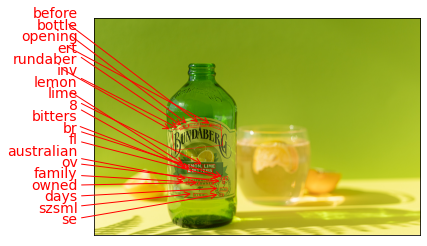

-------------------------------------------

[Tesseract]

:

ws i

i

(py


Ie

%

,

tig


LEMON

mm)

— . :

Done


In [20]:
compare_ocr('image3.jpg')


[Google OCR]
Texts:

"OUAI
MEDIUM HAIR
CHEVEUX MOYENS
CONDITIONER
REVITALISANT
10 fl oz /300 ml
OZ
"

"OUAI"

"MEDIUM"

"HAIR"

"CHEVEUX"

"MOYENS"

"CONDITIONER"

"REVITALISANT"

"10"

"fl"

"oz"

"/300"

"ml"

"OZ"
bounds: (1284,2989),(1316,2989),(1316,3005),(1284,3005)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


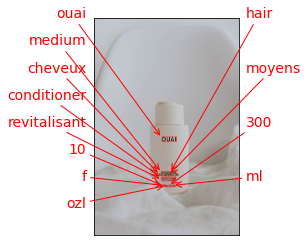

-------------------------------------------

[Tesseract]

Done


In [21]:
compare_ocr('image2.jpg')

### 2) 옆으로 누워있는 제품


[Google OCR]
Texts:

"BIODERMA
LABORATOIRE DERMATOLOGIQUE
Hydrabio
Gel-Crème
Oin hydratant
fexture légère
Sisturising care
Visage & Yeux
Face & Eyes
Hydrabio
ERA
Solution micellaire
démaquillante hydratante
Peaux sensibles déshydratées
Hypoallergénique
Light
Sans rinçage - Sans
paraben
AQUAGENIUM"
Moisturising make-up
removing micelle solution
free-Hypoallerg
Brevet/Patent AQUAGENIUM
500ml E 16.7 FL.OZ.
"

"BIODERMA"

"LABORATOIRE"

"DERMATOLOGIQUE"

"Hydrabio"

"Gel-Crème"

"Oin"

"hydratant"

"fexture"

"légère"

"Sisturising"

"care"

"Visage"

"&"

"Yeux"

"Face"

"&"

"Eyes"

"Hydrabio"

"ERA"

"Solution"

"micellaire"

"démaquillante"

"hydratante"

"Peaux"

"sensibles"

"déshydratées"

"Hypoallergénique"

"Light"

"Sans"

"rinçage"

"-"

"Sans"

"paraben"

"AQUAGENIUM""

"Moisturising"

"make-up"

"removing"

"micelle"

"solution"

"free-Hypoallerg"

"Brevet/Patent"

"AQUAGENIUM"

"500ml"

"E"

"16.7"

"FL.OZ."
bounds: (3646,4853),(3767,4571),(3885,4622),(3764,4904)
-----------

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


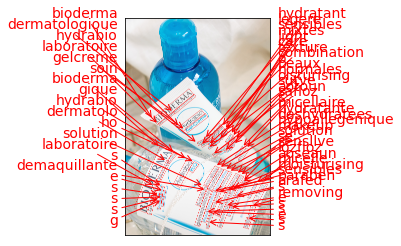

-------------------------------------------

[Tesseract]

Done


In [22]:
compare_ocr('image4.jpg')

### 3) 살짝 기울어지거나 잘 안보이는 제품


[Google OCR]
Texts:

"FABERLIC
Bioglow
My way to
use less
makeup
Крем
с жемчужным
эффектом
Illuminating
face cream
30 M/ml
FABERLIC
Bioglow
You're my
sunshine
Сыворотка
для лица
Serum
"

"FABERLIC"

"Bioglow"

"My"

"way"

"to"

"use"

"less"

"makeup"

"Крем"

"с"

"жемчужным"

"эффектом"

"Illuminating"

"face"

"cream"

"30"

"M/ml"

"FABERLIC"

"Bioglow"

"You're"

"my"

"sunshine"

"Сыворотка"

"для"

"лица"

"Serum"
bounds: (1156,4271),(1245,4312),(1229,4346),(1140,4305)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


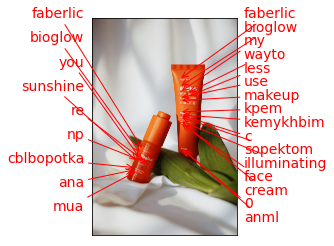

-------------------------------------------

[Tesseract]

c.


FABERLIC

—_


MY


a5

use



Pe Ce

a

eta ats

face cream

4


Done


In [25]:
compare_ocr('image1.jpg')


[Google OCR]
Texts:

"diptyque
34
paris
Baume Généreux
Ваите
pour les Mains
Luxurious Hand Balm
dipyque
paris
SUd 34
BAUME
GÉNÉREUX
L'ART DU SOIN
Refined, silky, protective. This
balm is rich in Apricot Kernel
Oil, which helps replenish dry,
dehydrated skin.
346
Aboulevard
saint germa
34boulc
boulevard saint
"

"diptyque"

"34"

"paris"

"Baume"

"Généreux"

"Ваите"

"pour"

"les"

"Mains"

"Luxurious"

"Hand"

"Balm"

"dipyque"

"paris"

"SUd"

"34"

"BAUME"

"GÉNÉREUX"

"L'ART"

"DU"

"SOIN"

"Refined,"

"silky,"

"protective."

"This"

"balm"

"is"

"rich"

"in"

"Apricot"

"Kernel"

"Oil,"

"which"

"helps"

"replenish"

"dry,"

"dehydrated"

"skin."

"346"

"Aboulevard"

"saint"

"germa"

"34boulc"

"boulevard"

"saint"
bounds: (665,1913),(635,1819),(693,1800),(723,1894)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


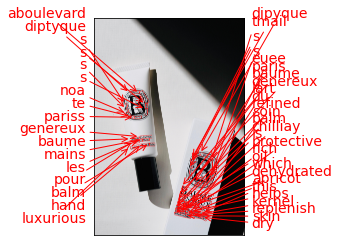

-------------------------------------------

[Tesseract]

Done


In [26]:
compare_ocr('image8.jpg')

### 4) 정면으로 잘 보이는 제품


[Google OCR]
Texts:

"MARIO
BADESCU
SKIN CARE
Established 1967
MB
MARI
BADES
FACIAL SPRAY
WITH ALOE,
CUCUMBER AND
SKINCA
Establishe
GREEN TE A
4 fl oz e (118 ml)
SKIN
TYPES
ALL
E 畫基手0国
"

"MARIO"

"BADESCU"

"SKIN"

"CARE"

"Established"

"1967"

"MB"

"MARI"

"BADES"

"FACIAL"

"SPRAY"

"WITH"

"ALOE,"

"CUCUMBER"

"AND"

"SKINCA"

"Establishe"

"GREEN"

"TE"

"A"

"4"

"fl"

"oz"

"e"

"(118"

"ml)"

"SKIN"

"TYPES"

"ALL"

"E"

"畫"

"基"

"手"

"0"

"国"
bounds: (3157,3589),(3177,3620),(3114,3662),(3093,3631)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


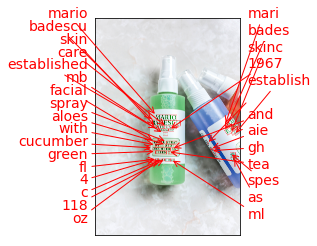

-------------------------------------------

[Tesseract]
SKIN

CARE

Fstablished

1967

‘ACIAL

SPRAY

WITH

ALOE.

UCUMBER

AND


GREEN

TEA

\y


Done


In [24]:
compare_ocr('image5.jpg')


[Google OCR]
Texts:

"Jo MAL ONE
LONDON
NECTARINE BLOSSOM
& HONEY
COLOGNE
"

"Jo"

"MAL"

"ONE"

"LONDON"

"NECTARINE"

"BLOSSOM"

"&"

"HONEY"

"COLOGNE"
bounds: (1546,3228),(1763,3230),(1763,3261),(1546,3259)
-------------------------------------------
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


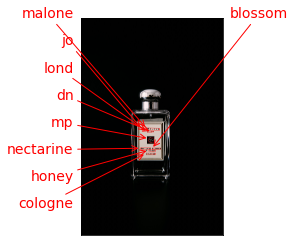

-------------------------------------------

[Tesseract]
JO

VIALONE

| OND ON

NECTARINE

rM1LOSSOM

Ex

MONE Y

( OLOGNE


Done


In [23]:
compare_ocr('image7.jpg')

## Step4. 결과 분석과 결론 제시

#### ✅ Google OCR API
    - image9.jpg를 보면 keras-ocr은 'HERETIC'을 'mlrttic'이라고 인식한 것을 google ocr은 제대로 'HERETIC'이라고 인식한 것을 볼 수 있는데 그림자가 져서 어둡게 보여도 잘 인식한다는 것을 알 수 있었다.
    - 아마 쓰게 된다면 이것을 쓰지 않을까 싶다.
#### ✅ keras-ocr
    - 대부분 제품 글자들을 잘 인식하는 편인 것 같다.
#### ✅ Tesseract
    - 전체적으로 제대로 잘 인식하지 못한 것 같다.
    - 특히나 살짝 어둡거나 그림자가 지면 제대로 인식을 못하는 것 같다.

# 🌟 루브릭

|평가문항|상세기준|
|:----------|:-----------|
|1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.|
|2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.|
|3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|

# 🌟 회고

▶️ 어려웠던 점 : Tesseract부분 실행할 때 'Cannot recognize characters from~'가 나오면서 아무것도 나온게 없었는데 다시 차근차근 실행시키다 보니 제대로 나왔다. 이 점 외에는 크게 어려웠던 점은 없었던 것 같다.    

▶️ Google OCR API를 쓰기 위해서 했던 과정들이 귀찮았지만 여러 OCR을 사용해서 비교해가는 과정들이 재미있었다.

# 🌟 참고

[kec0130 github](https://github.com/kec0130/AIFFEL-project/blob/main/exploration/E18_ocr_pjt.ipynb)